# Tarea 2: Red multi-capa en PyTorch

**Temas**: *red multi-capa, función de activación, pytorch, generalización,  normalización, regularización, optimizador*.



**El derrame del Río Sonora (México, 2014)**


En agosto de 2014, la mina Buenavista del Cobre vertió unas 40 000 m³ de solución ácida con arsénico, plomo, cadmio y cobre en el Río Sonora (México). El desastre dejó a comunidades rurales sin agua potable, arruinó cosechas y provocó problemas crónicos de salud, evidenciando la necesidad urgente de sistemas que detecten contaminantes en tiempo real y activen alertas antes de que el agua llegue a los hogares.

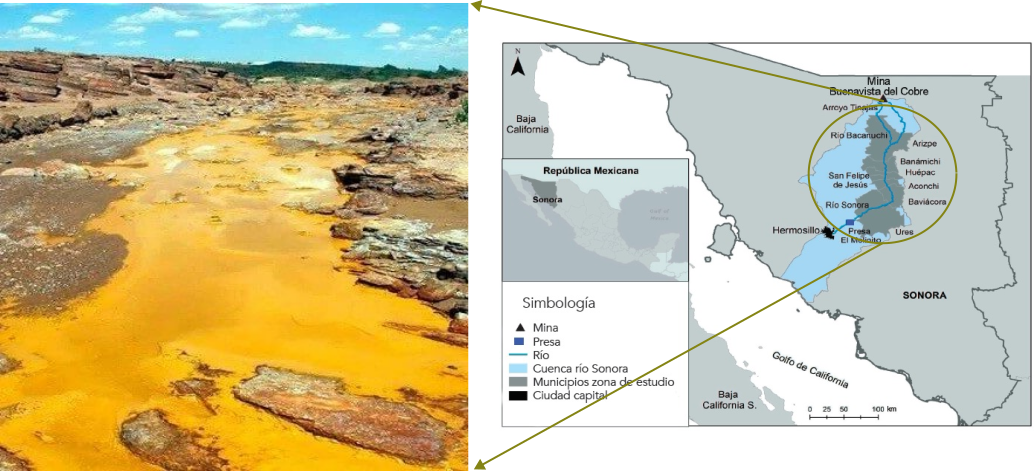

**Fuente**: Elaboración a partir de las imágenes de la hemeroteca virtual [Scielo](https://www.scielo.org.mx/scielo.php?script=sci_arttext&pid=S1870-39252021000100123) y de [Business and Human Rights Resource Centre](https://www.scielo.org.mx/scielo.php?script=sci_arttext&pid=S1870-39252021000100123)

Para ilustrar cómo los datos y el Deep Learning pueden alertar sobre riesgos en la calidad del agua, en ésta práctica usaremos el dataset sintético [Water Quality](https://www.kaggle.com/datasets/mssmartypants/water-quality/data): ≈ 8 000 registros que simulan concentraciones realistas de químicos y la etiqueta binaria is_safe (1 = segura, 0 = no segura).

**Qué aprenderás**

1. **Preprocesamiento con pandas**
  * Carga del CSV, manejo de valores faltantes y conversión de unidades.

  * Normalización de variables químicas para acelerar el entrenamiento.

2. **Construcción del modelo en PyTorch**

  * Definición de capas lineales con Batch Normalization y Dropout.

  * Uso de ReLU y Sigmoid.

  * Entrenamiento con los optimizadores SGD y Adam, comparando su impacto.

3. **Evaluación y experimentación**

  * Ajuste de hiperparámetros (tasa de aprendizaje, probabilidad de dropout).

  * Métricas de precisión.

  * Visualización de resultados para interpretar el modelo.


**Librerías a utilizar:**

*   `pandas`: Biblioteca para cargar, limpiar y transformar datos tabulares
*   `PyTorch`: Framework open-source que permite crear y entrenar redes neuronales dinámicas con tensores acelerados en CPU/GPU
*   `Matplotlib`: Librería base de visualización; genera gráficos 2D/3D personalizables para exploración y reportes
*   `Seaborn`: Permite producir visualizaciones de alto nivel con estilos coherentes.

**Instalación de librerías**

In [2]:
!pip install -q pandas
!pip install -q numpy
!pip install -q matplotlib
!pip install -q scikit-learn
!pip install -q seaborn
!pip install -q torch


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


**Importación de librerías**

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader

## 1. Preprocesamiento del dataset con pandas

El **preprocesamiento de datos** es el paso que convierte los datos crudos en un formato limpio, coherente y numéricamente estable antes de alimentar una red neuronal. Implica eliminar duplicados y valores atípicos, imputar o descartar nulos, normalizar escalas y codificar variables categóricas. Sin estos ajustes, los optimizadores pueden quedar atrapados en regiones planas o explotar por gradientes desbalanceados, lo que ralentiza la convergencia y reduce la capacidad de generalización. Preprocesar, por tanto, sienta las bases para que el modelo aprenda patrones reales en lugar de ruido, acelere el entrenamiento y ofrezca predicciones fiables.

En esta parte vamos a inspeccionar la distribución de químicos presentes en el agua, normalizar columnas numéricas y codificar la etiqueta. Para eso vamos a utilizar los siguientes métodos de pandas:

`df.head(n)` – Muestra las primeras n filas para una vista rápida del DataFrame.

`df.info()` – Resume tipos de datos, conteo de valores no nulos y uso de memoria.

`df.replace(a, b)` – Sustituye todas las ocurrencias de a por b en el DataFrame.

`df.dropna()` – Elimina filas o columnas que contienen valores nulos.

`df.columns` – Devuelve o permite reasignar la lista de nombres de columnas.

`df.describe()` – Genera estadísticas descriptivas (media, desvío, cuartiles) para las columnas numéricas.

`df.hist()` – Crea histogramas que muestran la distribución de cada variable numérica.

In [4]:
file_path = 'waterQuality1.csv'
# Cargar el conjunto de datos
df = pd.read_csv(file_path)
df.head()

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
0,1.65,9.08,0.04,2.85,0.007,0.35,0.83,0.17,0.05,0.20,...,0.054,16.08,1.13,0.007,37.75,6.78,0.08,0.34,0.02,1
1,2.32,21.16,0.01,3.31,0.002,5.28,0.68,0.66,0.90,0.65,...,0.100,2.01,1.93,0.003,32.26,3.21,0.08,0.27,0.05,1
2,1.01,14.02,0.04,0.58,0.008,4.24,0.53,0.02,0.99,0.05,...,0.078,14.16,1.11,0.006,50.28,7.07,0.07,0.44,0.01,0
3,1.36,11.33,0.04,2.96,0.001,7.23,0.03,1.66,1.08,0.71,...,0.016,1.41,1.29,0.004,9.12,1.72,0.02,0.45,0.05,1
4,0.92,24.33,0.03,0.20,0.006,2.67,0.69,0.57,0.61,0.13,...,0.117,6.74,1.11,0.003,16.90,2.41,0.02,0.06,0.02,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   aluminium    7999 non-null   float64
 1   ammonia      7999 non-null   object 
 2   arsenic      7999 non-null   float64
 3   barium       7999 non-null   float64
 4   cadmium      7999 non-null   float64
 5   chloramine   7999 non-null   float64
 6   chromium     7999 non-null   float64
 7   copper       7999 non-null   float64
 8   flouride     7999 non-null   float64
 9   bacteria     7999 non-null   float64
 10  viruses      7999 non-null   float64
 11  lead         7999 non-null   float64
 12  nitrates     7999 non-null   float64
 13  nitrites     7999 non-null   float64
 14  mercury      7999 non-null   float64
 15  perchlorate  7999 non-null   float64
 16  radium       7999 non-null   float64
 17  selenium     7999 non-null   float64
 18  silver       7999 non-null   float64
 19  uraniu

In [6]:
# Manejo de valores nulos
df.replace('#NUM!', np.nan, inplace=True)
df.dropna(inplace=True)

In [7]:
df.columns

Index(['aluminium', 'ammonia', 'arsenic', 'barium', 'cadmium', 'chloramine',
       'chromium', 'copper', 'flouride', 'bacteria', 'viruses', 'lead',
       'nitrates', 'nitrites', 'mercury', 'perchlorate', 'radium', 'selenium',
       'silver', 'uranium', 'is_safe'],
      dtype='object')

In [8]:
df.describe()

,aluminium,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,viruses,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium
count,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000
mean,0.666396,0.161477,1.567928,0.042803,2.177589,0.247300,0.805940,0.771646,0.319714,0.328706,0.099431,9.819250,1.329846,0.005193,16.465266,2.920106,0.049684,0.147811,0.044672
std,1.265323,0.252632,1.216227,0.036049,2.567210,0.270663,0.653595,0.435423,0.329497,0.378113,0.058169,5.541977,0.573271,0.002967,17.688827,2.322805,0.028773,0.143569,0.026906
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.040000,0.030000,0.560000,0.008000,0.100000,0.050000,0.090000,0.407500,0.000000,0.002000,0.048000,5.000000,1.000000,0.003000,2.170000,0.820000,0.020000,0.040000,0.020000
50%,0.070000,0.050000,1.190000,0.040000,0.530000,0.090000,0.750000,0.770000,0.220000,0.008000,0.102000,9.930000,1.420000,0.005000,7.745000,2.410000,0.050000,0.080000,0.050000
75%,0.280000,0.100000,2.482500,0.070000,4.240000,0.440000,1.390000,1.160000,0.610000,0.700000,0.151000,14.610000,1.760000,0.008000,29.487500,4.670000,0.070000,0.240000,0.070000
max,5.050000,1.050000,4.940000,0.130000,8.680000,0.900000,2.000000,1.500000,1.000000,1.000000,0.200000,19.830000,2.930000,0.010000,60.010000,7.990000,0.100000,0.500000,0.090000


Vamos a graficar los histogramas de cada variable numérica

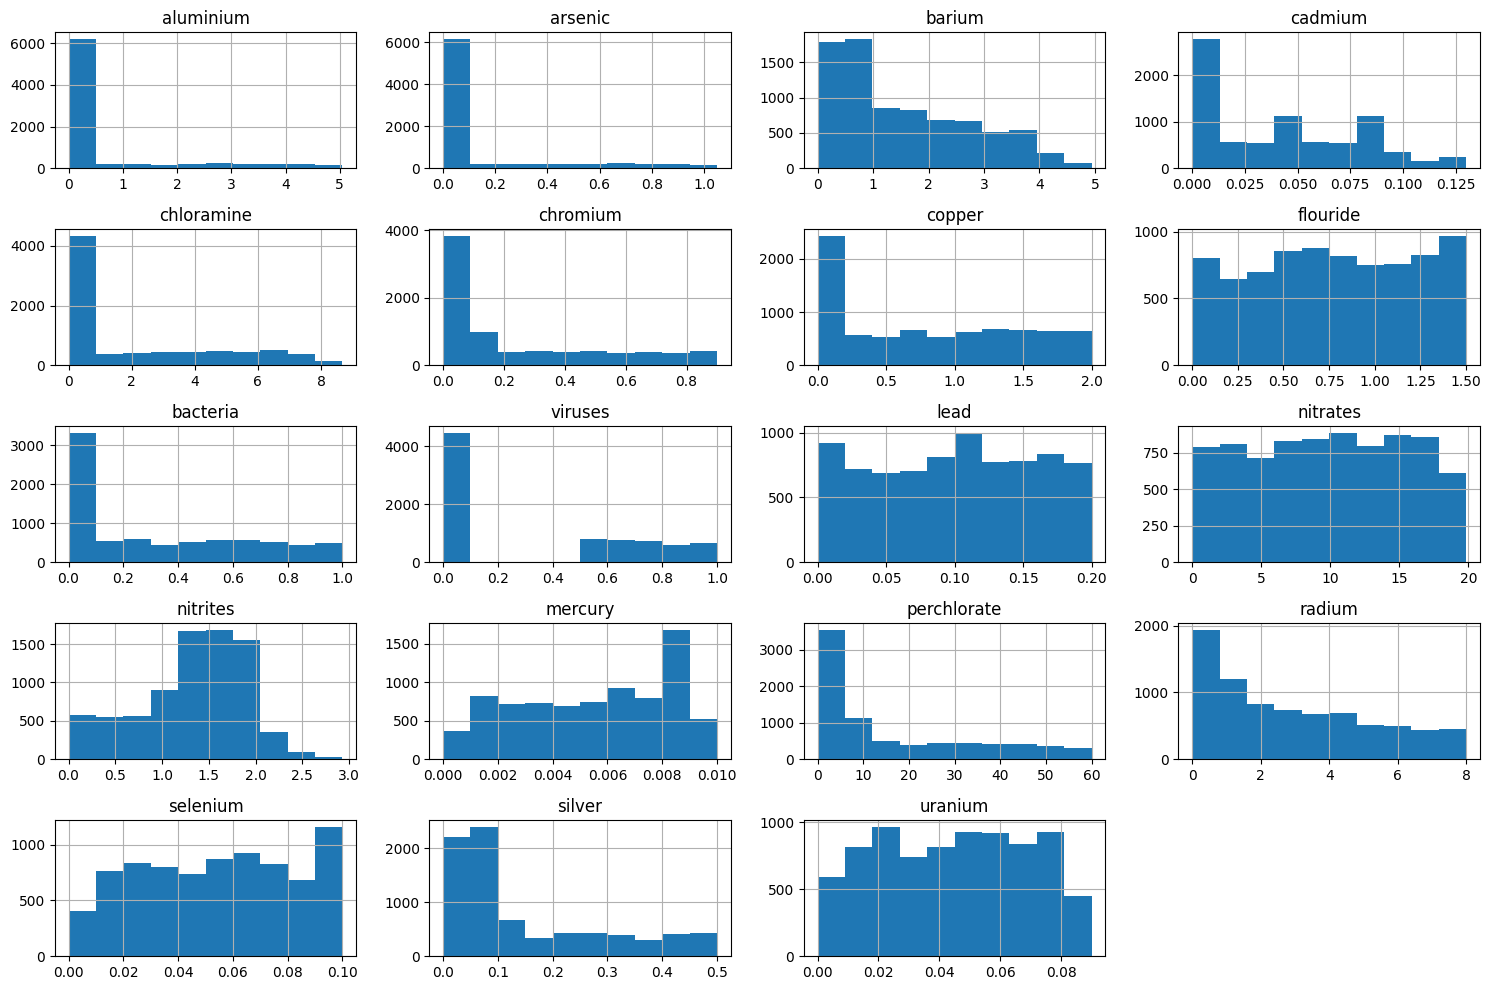

In [9]:
# Visualizar las distribuciones de características numéricas
df.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

Por defecto el histograma no muestra la distrubución de la columna `*is_safe*`, asi que podemos visualizarlo manualmente. El gráfico nos muestra que tenemos datos desbalanceados. Este desequilibrio induce a los modelos a optimizar la precisión global favoreciendo la clase mayoritaria: un clasificador que siempre prediga la clase frecuente puede dar una “alta” accuracy pero fallar justamente donde más interesa. Para mitigar el problema se recurre a (1) **métricas adecuadas** como F1-score, recall o AUC-ROC, (2) **pérdidas ponderadas** (pos_weight en BCEWithLogitsLoss o weight en CrossEntropy) que penalizan más los errores sobre la clase minoritaria, (3) **re-muestreo**: sobremuestrear la clase escasa (SMOTE, duplicación) o submuestrear la abundante, y (4) **algoritmos especializados** (ensembles balanceados, focal loss). Aplicar estas estrategias permite que la red aprenda patrones relevantes en ambas clases y mejore la capacidad de detección de eventos poco frecuentes sin degradar la precisión global.

En nuestro caso vamos a aplicar las pérdidas ponderadas, en la sección de *Entrenamiento y Validación*

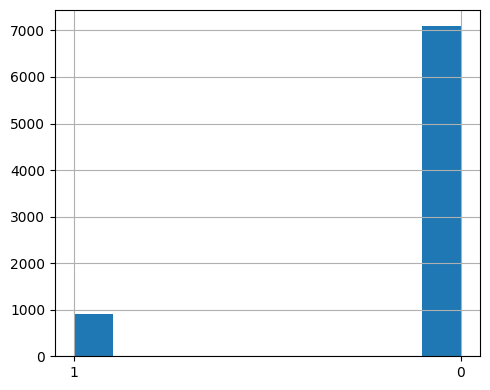

In [10]:
df.is_safe.hist(figsize=(5, 4))
plt.tight_layout()
plt.show()

A continuación se muestra la matriz de correlación, el cual es una tabla cuadrada que muestra, para cada par de variables numéricas, un coeficiente entre –1 y 1 que indica qué tan fuerte y en qué dirección varían juntas (positiva, negativa o sin relación).
Para graficarlo utilizaremos la libreria *seaborn*

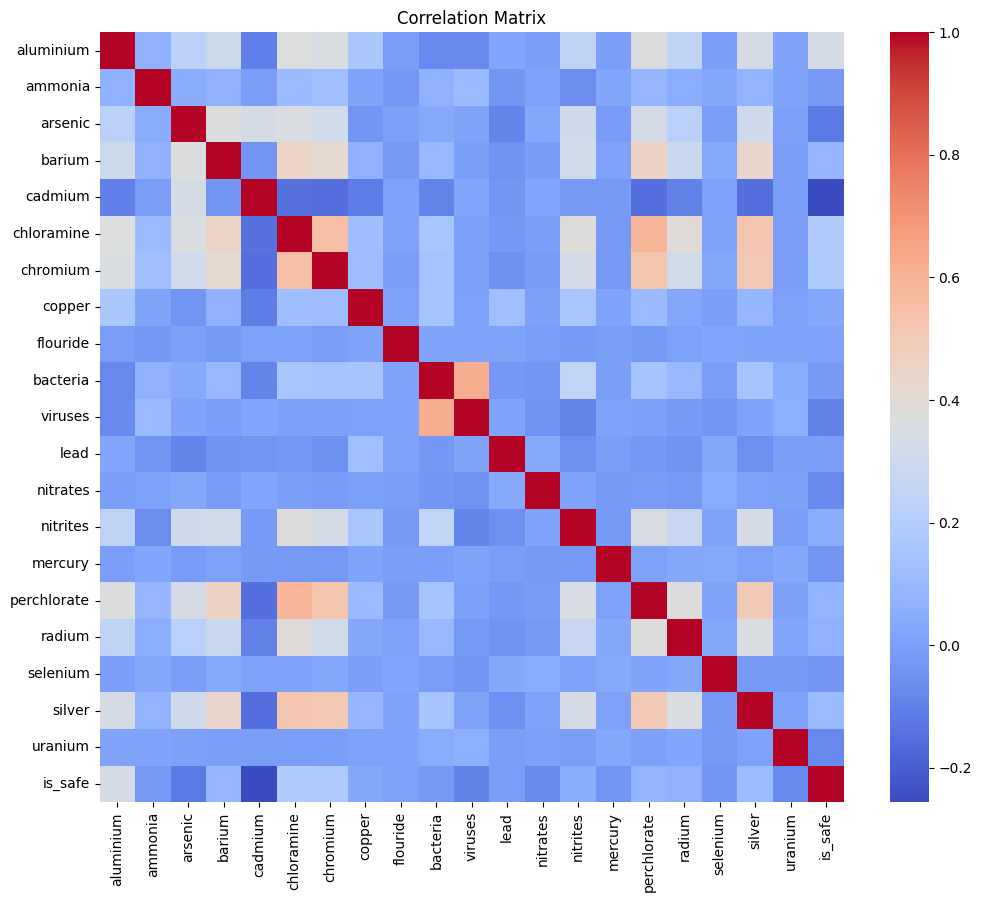

In [11]:
# Graficar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Para el entrenamiento necesitamos separar el dataset en ***features (X)*** y ***target (y)*** ya que necesitamos aislar las columnas que contienen los predictores (variables de entrada) de la columna objetivo.

In [12]:
X = df.drop(columns=['is_safe'])
y = df['is_safe']

### Actividad 1: Normalización de datos

La normalización pone todas las variables en escalas comparables, para evitar que atributos con rangos mayores dominen el aprendizaje, de esa forma acelera la convergencia de los optimizadores y mejora la estabilidad numérica de los modelos.

Para normalizar el dataset vamos a utilizar:

`StandardScaler`: transforma cada característica numérica para que tenga media 0 y desviación estándar 1.

`LabelEncoder`: codifica etiquetas categóricas como enteros consecutivos, preparándolas para algoritmos que solo aceptan valores numéricos.

A continuación normaliza tanto los *features (X)* como el *target (y)* del dataset

In [13]:
labelencoder = LabelEncoder()
scaler = StandardScaler()
# your code here
X = pd.DataFrame(scaler.fit_transform(X))
y = pd.Series(labelencoder.fit_transform(y))

#### Test para evaluar la normalización de los datos

## 2. Diseño de la red multicapa en PyTorch


Las redes multi-capa (MLP) son una pila de capas totalmente conectadas con activaciones no lineales que aprenden representaciones jerárquicas de los datos.

En este caso vamos a construir tres modelos en PyTorch, con una estructura base pero con algunas configuraciones diferentes. Pra ello vamos a utilizar las siguientes clases.

`torch.nn.Module`: define el modelo base que requiere declarar las capas en __init__ y definir el flujo de datos en forward().

`nn.Linear`: capa densa que aplica una transformación afín $y = Wx + by$ a cada muestra, aprendiendo pesos y sesgos.

`nn.BatchNorm1d`: normaliza cada característica de un mini-batch a media 0 y varianza 1, luego ajusta con parámetros aprendibles $γ, β$ para acelerar y estabilizar el entrenamiento.

### Actividad 2: Red multi-capa

En esta actividad, implementarás una red con cinco capas lineales y normalización para cada una. Dado que se trata de un problema de clasificación con valor binario, la salida del modelo tiene que ser de tamaño 1.

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [15]:
class QualityWaterClassifier1(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        # your code here
        self.capa1 = nn.Linear(input_size, 10)
        self.capa2 = nn.Linear(10, 10)
        self.capa3 = nn.Linear(10, 10)
        self.capa4 = nn.Linear(10, 10)
        self.capa_salida = nn.Linear(10, output_size)
        
        self.norm = nn.BatchNorm1d(10)

    def forward(self, x):
        # your code here
        x = self.capa1(x)
        x = self.norm(x)
        
        x = self.capa2(x)
        x = self.norm(x)
        
        x = self.capa3(x)
        x = self.norm(x)
        
        x = self.capa4(x)
        x = self.norm(x)
        
        x = self.capa_salida(x)
        return x

#### Tests para evaluar la normalización en la red

### Actividad 3: Red multi-capa con función de activación

Una **función de activación** introduce no linealidad en las salidas de una capa neuronal, permitiendo que la red modele relaciones complejas; además, acota o transforma los valores (p. ej., *ReLU, Sigmoid*) para facilitar el aprendizaje y la propagación eficaz de gradientes.

`ReLU (Rectified Linear Unit)`: activa sólo valores positivos, evita el problema de gradientes pequeños y mantiene la red eficiente; su fórmula es $f(x) = max⁡(0,x)$.

`Sigmoid`: comprime la salida al rango (0, 1), útil para probabilidades en clasificación binaria; su fórmula es $f(x) = \frac{1}{1 + e⁻x}$.

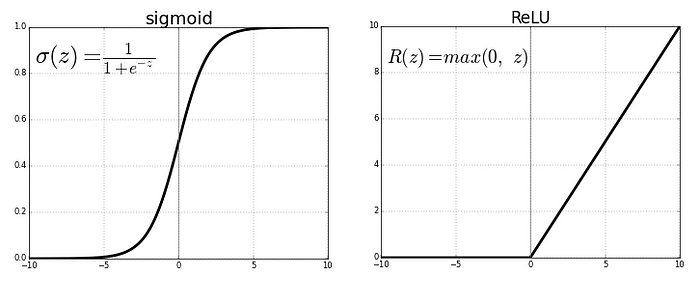

Fuente de la imagen: [Understanding the Difference Between ReLU and Sigmoid Activation Functions in Deep Learning](https://medium.com/@srivastavashivansh8922/understanding-the-difference-between-relu-and-sigmoid-activation-functions-in-deep-learning-33b280fc2071)

Para la actividad tienes que crear un modelo similar al anterior pero agregando función de activación. Es importante destacar, que durante el entrenamiento del modelo se va a utilizar la función de pérdida BCEWithLogitsLoss, dado que se trata de un problema de clasificación binaria. Como esta pérdida utiliza una función sigmoide internamente, no es necesario agregarlo en la última capa.

[`torch.nn.BCEWithLogitsLoss`](https://docs.pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) calcula la entropía cruzada binaria sobre logits, integrando internamente la función sigmoide para mayor estabilidad numérica y permitiendo ponderar la clase positiva mediante `pos_weight`.

In [16]:
class QualityWaterClassifier2(QualityWaterClassifier1):
    def __init__(self, input_size, output_size):
        super().__init__(input_size, output_size)
        # your code here
        # capas
        self.capa1 = nn.Linear(input_size, 10)
        self.capa2 = nn.Linear(10, 10)
        self.capa3 = nn.Linear(10, 10)
        self.capa4 = nn.Linear(10, 10)
        self.capa_salida = nn.Linear(10, output_size)
        
        # Normalizador
        self.norm = nn.BatchNorm1d(10)
        
        # funcion de activacion
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # your code here
        x = self.capa1(x)
        x = self.norm(x)
        x = self.relu(x)
        
        x = self.capa2(x)
        x = self.norm(x)
        x = self.relu(x)
        
        x = self.capa3(x)
        x = self.norm(x)
        x = self.relu(x)
        
        x = self.capa4(x)
        x = self.norm(x)
        x = self.relu(x)
        
        x = self.capa_salida(x)
        return x

#### Tests para evaluar la función de activación en la red

### Actividad 4: Red multicapa con regularización

Regularización es el conjunto de técnicas que añaden restricciones al entrenamiento para evitar que una red memorice los datos (sobreajuste) y mejore su capacidad de generalización. Por su parte, **dropout** es una forma de regularización que, durante cada paso de entrenamiento, “apaga” aleatoriamente un porcentaje $p$ de neuronas (pone sus salidas a 0); esto obliga a la red a no depender de rutas específicas, crea un “ensamble” implícito de sub-modelos y reduce el sobreajuste sin añadir costo computacional en la fase de inferencia.

La actividad consiste en agregar dropout al modelo construido en la etapa anterior.

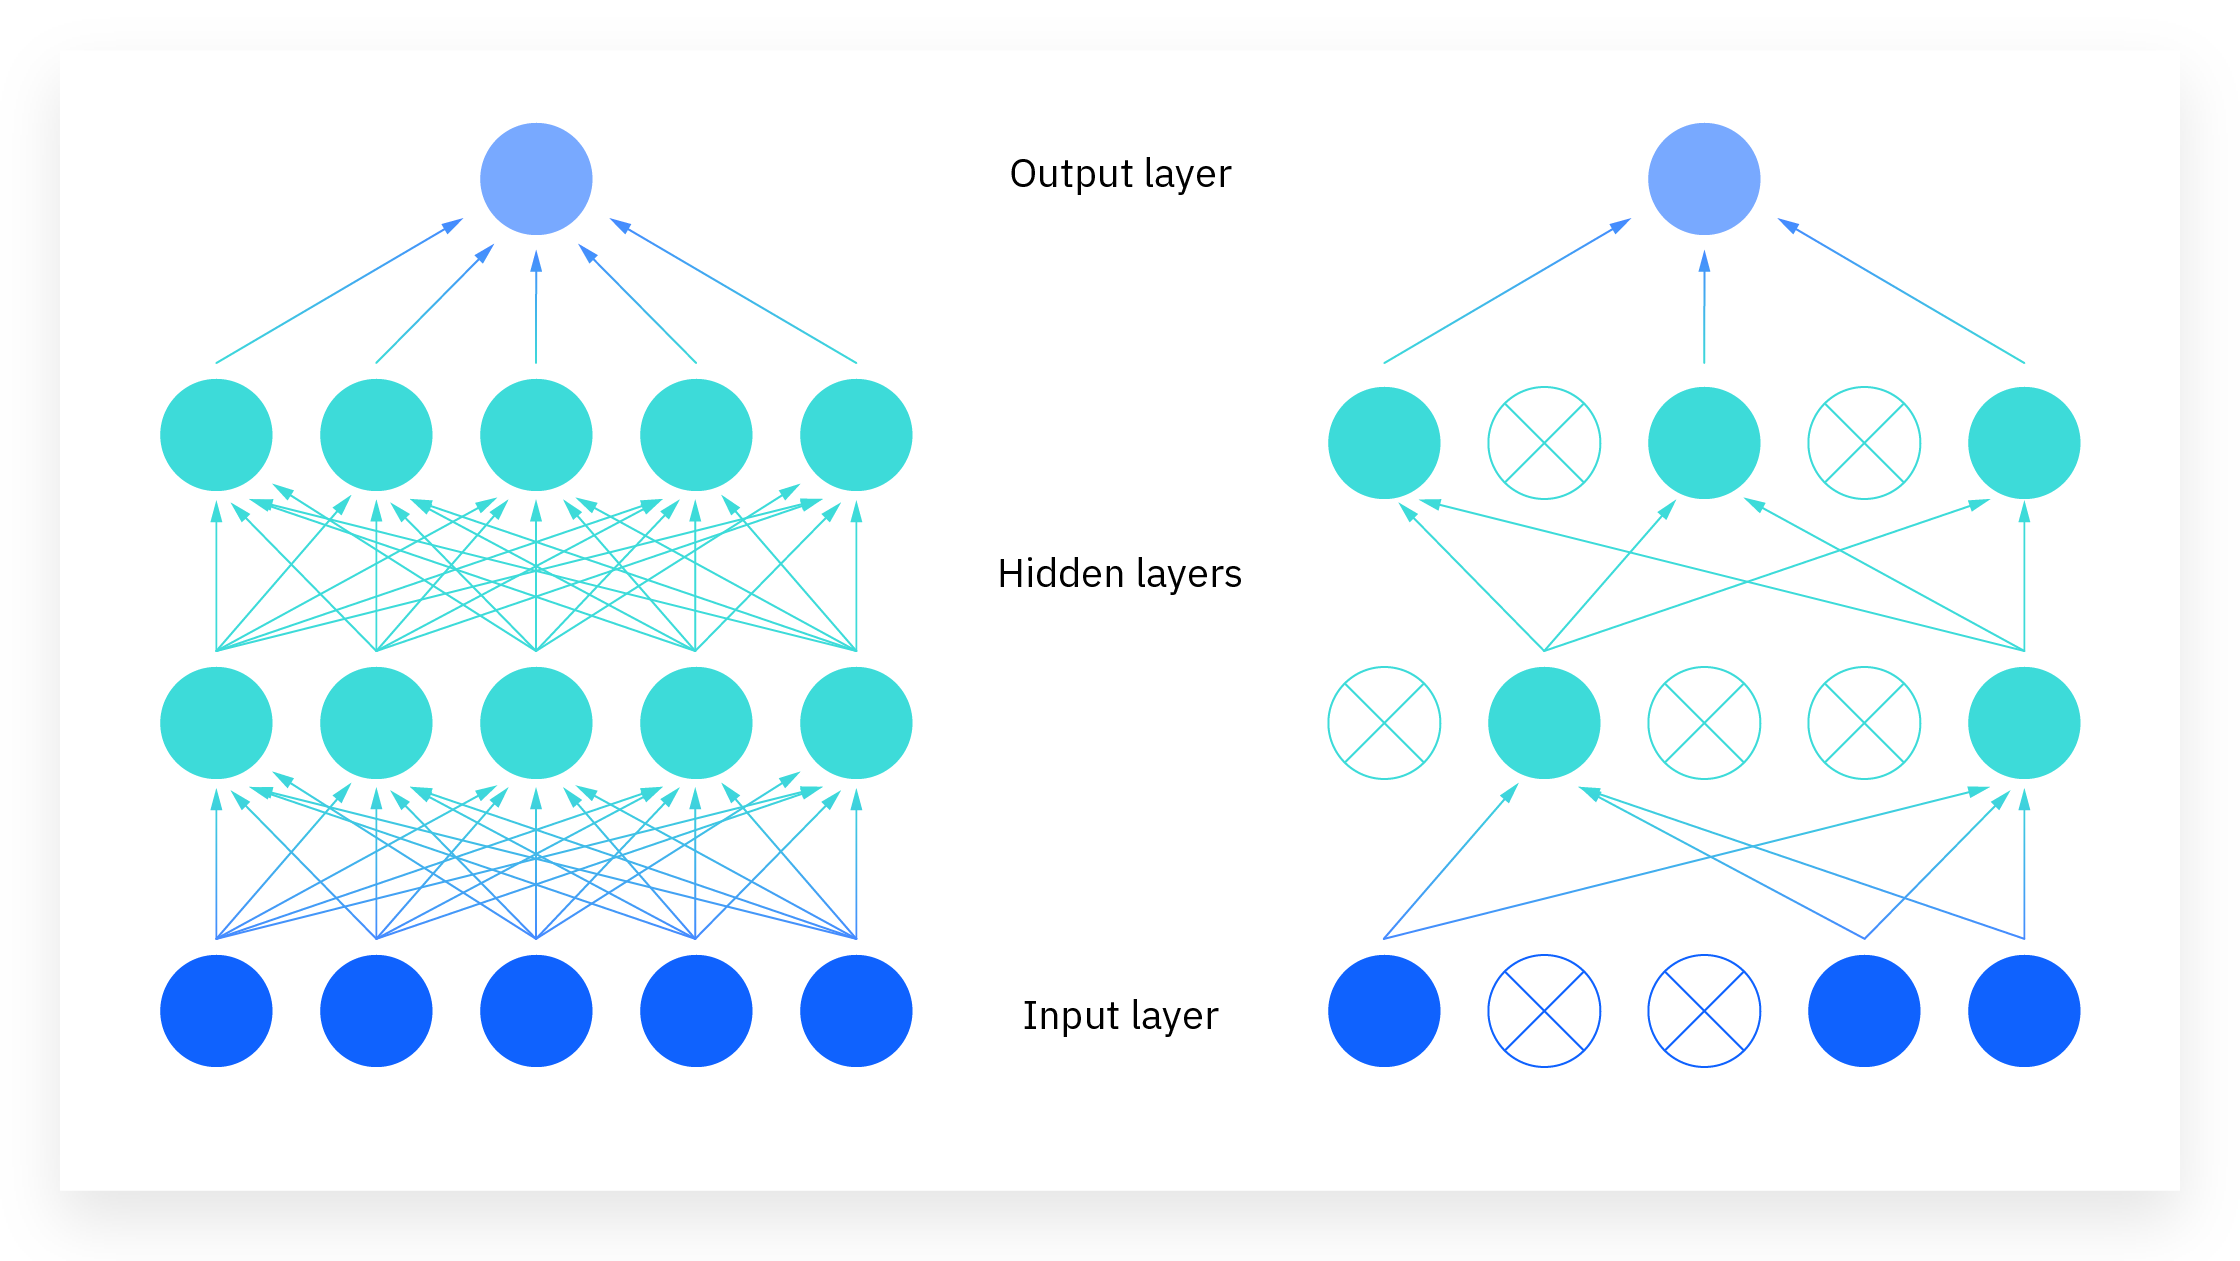

Fuente de la imagen: [What is regularization?](https://www.ibm.com/think/topics/regularization)

In [17]:
class QualityWaterClassifier3(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        # your code here
        # capas
        self.capa1 = nn.Linear(input_size, 10)
        self.capa2 = nn.Linear(10, 10)
        self.capa3 = nn.Linear(10, 10)
        self.capa4 = nn.Linear(10, 10)
        self.capa_salida = nn.Linear(10, output_size)
        
        # Normalizador
        self.norm = nn.BatchNorm1d(10)
        
        # funcion de activacion
        self.relu = nn.ReLU()
        
        
        # Regularizacion
        self.dropout =  nn.Dropout(p=0.2)

    def forward(self, x):
        # your code here
        x = self.capa1(x)
        x = self.norm(x)
        x = self.relu(x)
        
        x = self.capa2(x)
        x = self.norm(x)
        x = self.relu(x)
        
        x = self.capa3(x)
        x = self.norm(x)
        x = self.relu(x)
        
        x = self.capa4(x)
        x = self.norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        
        
        x = self.capa_salida(x)
        return x

#### Tests para evaluar la regularización en la red

## Entrenamiento y validación


El **entrenamiento** ajusta los parámetros del modelo minimizando la pérdida sobre un conjunto de datos conocido, mientras que la **validación** evalúa ese modelo en datos que no ha visto para medir su capacidad de generalizar.

A continuación se tienen métodos que se van a utilizar durante el entrenamiento y validación.

In [18]:
def evaluate_model(model, val_dl, loss_function):
    total_loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for X, y in val_dl:
            X = X.cuda()
            y = y.cuda()
            y = y.float()
            # Forward pass
            output = model(X)
            # For binary classification with sigmoid output
            prediction = (output > 0.5).int().squeeze()
            # Compute loss
            loss = loss_function(output, y)
            total_loss += loss.item()
    return total_loss/len(val_dl), accuracy/len(val_dl)

def training(model, train_dl, val_dl, loss_function, optimizer, n_epochs, print_output=True, n_print=10):
    train_losses = []
    val_losses = []
    model.train()
    for epoch in range(1, n_epochs + 1):
        train_loss = 0
        for X, y in train_dl:
            # Mover datos a GPU
            X = X.cuda()
            y = y.cuda()
            y = y.float()
            output = model(X)
            loss = loss_function(output, y)
            optimizer.zero_grad()
            loss.backward()
            # Actualizar los pesos
            optimizer.step()
            # agregar el resultado de la perdida
            train_loss += loss.item()

        train_losses.append(train_loss/len(train_dl))

        val_loss, _ = evaluate_model(model, val_dl, loss_function)
        val_losses.append(val_loss)
        if print_output:
            if epoch % n_print == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}")
    torch.cuda.empty_cache()
    return train_losses, val_losses

def get_predictions(model, test_dl, device):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.round(torch.sigmoid(outputs))
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    return all_labels, all_preds

def plot_loss(train_loss, val_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Evolution of Loss during Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def get_pos_weight(series, device):
    unique, counts = np.unique(series, return_counts=True)
    frequency = dict(zip(unique, counts))
    n_neg = frequency['0']
    n_pos = frequency['1']
    pos_weight = torch.tensor([n_neg / n_pos], device=device)
    return pos_weight

### Actividad 5: División de datos train/val/test

Separar los datos en **entrenamiento, validación y test** es esencial para medir de forma honesta la capacidad de generalización de un modelo:

* Conjunto de entrenamiento. Se utiliza para ajustar los parámetros del modelo minimizando la pérdida en cada época (epoch)
* Conjunto de validación. Utilizado para vigilar el rendimiento del modelo fuera del entrenamiento, ajustar los hiperparámetros, ajustar patrones de regularización y el criterio de early stopping
* Conjunto de test. Es una submuestra de datos que no es utilizada para entrenar ni ajustar hiperparámetros; se reserva hasta el final para medir, de forma imparcial y definitiva, cómo se comportará el modelo con ejemplos completamente nuevos.

En esta actividad tienes que generar dos divisiones de datos con los esquemas dados. Puedes usar el método `train_test_split` de *sklearn*

**Nota:** Para la división se recomienda estratificar el conjunto de datos

In [19]:
X = df.drop(columns=['is_safe'])
y = df['is_safe']

Divide el dataset en 80% para el entrenamiento, 10% para test y 10% para validación

In [20]:
"""
X_train1 = ....
y_train1 = ....
X_val1 = ....
y_val1 = ....
X_test1 = ....
y_test1 = ....
"""
# your code here
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val1, X_test1, y_val1, y_test1 = train_test_split(X_test1, y_test1, test_size=0.5, random_state=42, stratify=y_test1)

Divide el dataset en 90% para el entrenamiento, 5% para test y 5% para validación

In [21]:
"""
X_train2 = ....
y_train2 = ....
X_val2 = ....
y_val2 = ....
X_test2 = ....
y_test2 = ....
"""
# your code here
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_test2, y_test2, test_size=0.5, random_state=42, stratify=y_test2)

#### Tests para evaluar la división de datos



Selecciona la división de datos que vas a utilizar para el entrenamiento

In [22]:
X_train = X_train1
y_train = y_train1
X_val = X_val1
y_val = y_val1
X_test = X_test1
y_test = y_test1

In [23]:
# método para convertir un dataframe a tensor
def convert2tensor(X, y):
    tensor_X = torch.tensor(X.values.astype(np.float32))
    tensor_y = torch.tensor(y.values.astype(np.int64), dtype=torch.long).unsqueeze(1)
    return TensorDataset(tensor_X, tensor_y)

In [24]:
train_dataset = convert2tensor(X_train, y_train)
val_dataset = convert2tensor(X_val, y_val)
test_dataset = convert2tensor(X_test, y_test)

train_dl = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=128, shuffle=False)

### **Función de optimización**

En Deep Learning, optimizar significa encontrar los valores de los pesos $θ$ que minimizan una función de pérdida $L(θ)$ sobre los datos. Entre los optimizadores más conocidos están:

* `Stochastic Gradient Descent (SGD)`. Usa mini-batches para estimar el gradiente, reduciendo coste computacional y añadiendo ruido beneficioso que ayuda a escapar de mínimos locales.
* `Adam (Adaptive Moment Estimation)`. Mantiene promedios exponenciales del gradiente y de su cuadrado, adaptando la tasa de aprendizaje para cada parámetro.

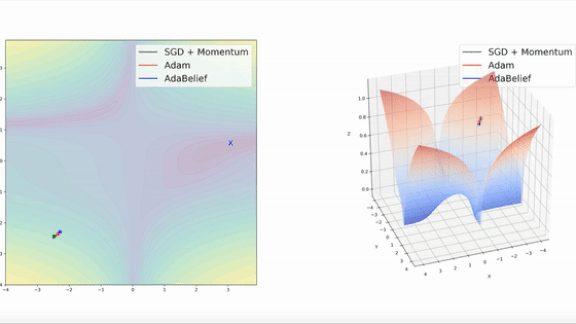

Fuente de la imagen: [Striding Toward the Minimum](https://www.deeplearning.ai/the-batch/striding-toward-the-minimum/)

### Actividad 6: Optimizador SGD

`torch.optim.SGD` implementa el descenso de gradiente estocástico clásico en PyTorch, actualizando los parámetros con una tasa de aprendizaje fija y opciones de momentum, weight decay y Nesterov para acelerar la convergencia y ayudar a la generalización.

Para la actividad tienes que definir el optimizador SGD en la variable *`optimizer`* y el seleccionar uno de los tres modelos implementados previamente en la variable *`model`*

In [25]:
# model = 
# optimizer =
# your code here
model = QualityWaterClassifier2(input_size=X.shape[1], output_size=1)
optimizer = SGD(model.parameters(), lr=0.01)
model.to('cuda')

QualityWaterClassifier2(
  (capa1): Linear(in_features=20, out_features=10, bias=True)
  (capa2): Linear(in_features=10, out_features=10, bias=True)
  (capa3): Linear(in_features=10, out_features=10, bias=True)
  (capa4): Linear(in_features=10, out_features=10, bias=True)
  (capa_salida): Linear(in_features=10, out_features=1, bias=True)
  (norm): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
)

In [26]:
pos_weight = get_pos_weight(y_train, device)
loss_function = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
n_epochs = 100

train_loss, val_loss = training(model, train_dl, val_dl, loss_function, optimizer, n_epochs, n_print=10)
print(f"Train loss: {np.mean(train_loss)}, Validation loss: {np.mean(val_loss)}")

Epoch 10, Train Loss: 60.736378371715546, Val Loss: 1.2173641920089722
Epoch 20, Train Loss: 56.03821504116058, Val Loss: 1.1152369805744715
Epoch 30, Train Loss: 49.6142241358757, Val Loss: 1.002379868711744
Epoch 40, Train Loss: 46.229491114616394, Val Loss: 0.8745013475418091
Epoch 50, Train Loss: 43.942457020282745, Val Loss: 0.8014988132885524
Epoch 60, Train Loss: 42.24420726299286, Val Loss: 0.833869993686676
Epoch 70, Train Loss: 41.04738664627075, Val Loss: 0.747742371899741
Epoch 80, Train Loss: 40.84468066692352, Val Loss: 0.7406155552182879
Epoch 90, Train Loss: 41.32110983133316, Val Loss: 0.8494437336921692
Epoch 100, Train Loss: 39.171407639980316, Val Loss: 0.7028205650193351
Train loss: 0.9439784136891366, Validation loss: 0.9144346929447991


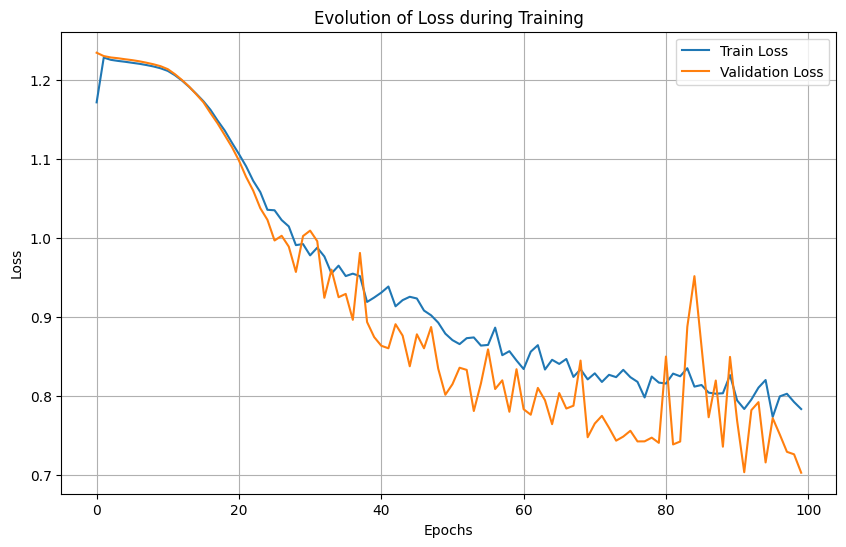

In [27]:
plot_loss(train_loss, val_loss)

`classification_report` genera un resumen en texto con precisión, recall, F1-score y soporte para cada clase, más sus promedios (micro, macro, weighted), facilitando la evaluación integral de un modelo de clasificación.

In [28]:
all_labels, all_preds = get_predictions(model, test_dl, device)
report = classification_report(all_labels, all_preds)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.82      0.89       709
           1       0.35      0.73      0.47        91

    accuracy                           0.81       800
   macro avg       0.65      0.77      0.68       800
weighted avg       0.89      0.81      0.84       800



#### Tests para evaluar el optimizador SGD

### Actividad 7: Optimizador Adam

`torch.optim.Adam` combina descenso de gradiente con momentos adaptativos. De esa forma, mantiene promedios exponenciales del gradiente y su cuadrado para ajustar automáticamente la tasa de aprendizaje de cada parámetro, logrando convergencia rápida con poco ajuste.

Para la actividad tienes que definir el optimizador Adam en la variable *`optimizer`* y el seleccionar uno de los tres modelos implementados previamente en la variable *`model`*

In [31]:
# model =
# optimizer =
# your code here
model = QualityWaterClassifier3(input_size=X.shape[1], output_size=1)
optimizer = Adam(model.parameters(), lr=0.01)
model.to('cuda')

QualityWaterClassifier3(
  (capa1): Linear(in_features=20, out_features=10, bias=True)
  (capa2): Linear(in_features=10, out_features=10, bias=True)
  (capa3): Linear(in_features=10, out_features=10, bias=True)
  (capa4): Linear(in_features=10, out_features=10, bias=True)
  (capa_salida): Linear(in_features=10, out_features=1, bias=True)
  (norm): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [36]:
pos_weight = get_pos_weight(y_train, device)
loss_function = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

n_epochs = 100

train_loss, val_loss = training(model, train_dl, val_dl, loss_function, optimizer, n_epochs, n_print=10)
print(f"Train loss: {np.mean(train_loss)}, Validation loss: {np.mean(val_loss)}")

Epoch 10, Train Loss: 34.08270752429962, Val Loss: 0.6000644224030631
Epoch 20, Train Loss: 30.242716282606125, Val Loss: 0.5413834154605865
Epoch 30, Train Loss: 28.764258593320847, Val Loss: 0.4939132503100804
Epoch 40, Train Loss: 24.848255455493927, Val Loss: 0.553652143904141
Epoch 50, Train Loss: 22.39552040398121, Val Loss: 0.502556962626321
Epoch 60, Train Loss: 21.158296540379524, Val Loss: 0.41070547699928284
Epoch 70, Train Loss: 19.677588939666748, Val Loss: 0.46073407360485624
Epoch 80, Train Loss: 19.351356506347656, Val Loss: 0.4195969211203711
Epoch 90, Train Loss: 18.90874718129635, Val Loss: 0.4214969575405121
Epoch 100, Train Loss: 16.78308643400669, Val Loss: 0.4049245928015028
Train loss: 0.5087888462662697, Validation loss: 0.5197166645739759


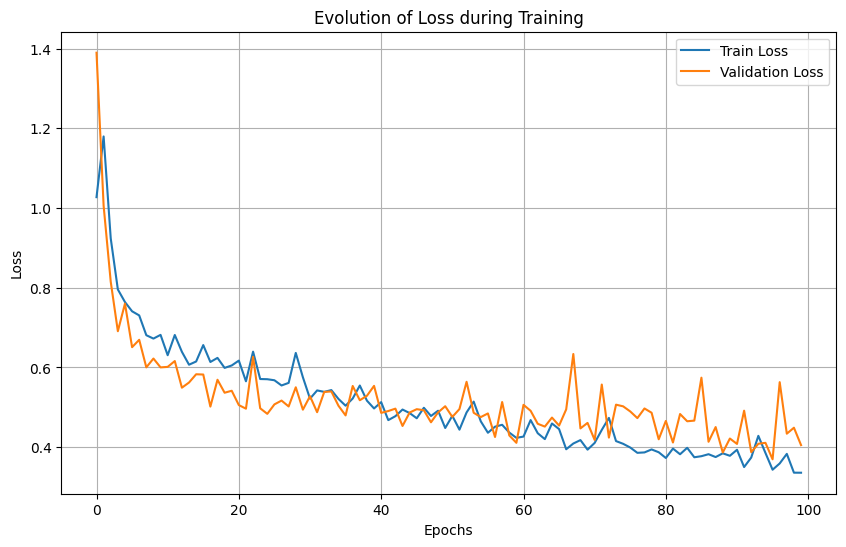

In [37]:
plot_loss(train_loss, val_loss)

In [34]:
all_labels, all_preds = get_predictions(model, test_dl, device)
report = classification_report(all_labels, all_preds)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       709
           1       0.50      0.77      0.61        91

    accuracy                           0.89       800
   macro avg       0.74      0.84      0.77       800
weighted avg       0.92      0.89      0.90       800



#### Tests para evaluar el optimizador Adam

### Actividad 8: Configuración óptima de entrenamiento

A partir de las tres arquitecturas que ya implementaste selecciona la variante que ofrezca mejor desempeño, define el optimizador con sus hiperparámetros clave y establece el número de epochs. Esta configuración será utilizada para evaluar el rendimiento del modelo.

In [38]:
"""
model =
optimizer =
n_epochs =
"""
# your code here
model = QualityWaterClassifier3(input_size=X.shape[1], output_size=1)
optimizer = Adam(model.parameters(), lr=0.01)
n_epochs = 50
model.to('cuda')

QualityWaterClassifier3(
  (capa1): Linear(in_features=20, out_features=10, bias=True)
  (capa2): Linear(in_features=10, out_features=10, bias=True)
  (capa3): Linear(in_features=10, out_features=10, bias=True)
  (capa4): Linear(in_features=10, out_features=10, bias=True)
  (capa_salida): Linear(in_features=10, out_features=1, bias=True)
  (norm): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

#### Tests para evaluar el rendimiento del modelo